In [1]:
import numpy as np
from scipy import optimize
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import gamma
from math import pi
#pip install fbm==0.1.0
from fbm import FBM

Simulate VA by diffusing Fractional Brownian Motion

In [2]:
def evol_va(mu,sigma_a,fbm_sample,times,H):
    VA=np.exp( mu*times - ((sigma_a**2)/2)*(times**(2*H)) + sigma_a*fbm_sample)
    return(VA)

Method 1 to obtain sigma and H. Sigma is obtained from H (more potential error).

In [44]:
def find_H_sigma(VA):
    n = VA.shape[0]

    delta_t=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    frequency = []
    for d in delta_t:
        frequency.append(n // d)
    
    #resampe with different frequencies
    asset_values={}
    for f in frequency:
        fasset_values = []
        days = []
        for i in range(n):
            if i % (n // f) == 0 :
                days.append(i)
        for day in days:
            fasset_values.append(VA[day])
        asset_values[f] = fasset_values

    #calculate Variance and Mean for every frequency
    Var = []
    for i, f in enumerate(frequency):
        Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )

    Mean = []
    for i, f in enumerate(frequency):
        Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))
    var_tau = np.array(Var)


    # Transformation logarithmique
    log_delta_t = np.log(delta_t)
    log_var_tau = np.log(var_tau)

    fixed_intercept_log_sigma2 = np.log(var_tau[0]) # assuming delta = 1 otherwise H is here

    # Régression linéaire
    X = log_delta_t.reshape(-1, 1)
    y = log_var_tau - fixed_intercept_log_sigma2


    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    #print('Regression score for H is ',model.score(X, y))

    # Coefficients de la régression
    slope = model.coef_[0]

    # Calcul de H
    H = slope / 2
    sigma_A = np.sqrt(var_tau[0]) * ((int(n/delta_t[0]))**(H))
    #for i in range(len(delta_t)):
    #    print(np.sqrt(var_tau[i]) * np.sqrt(int(n/delta_t[i])))

    return sigma_A, H

Method 2.
H is obtained with the method detailed on the Hurst exponent wiki page
The Calculation for Sigma appears different but it is in fact the same (from Cajueiro, Daniel O. and Fajardo, José, Volatility Estimation and Option Pricing with Fractional Brownian Motion (October 27, 2005). Available at SSRN: https://ssrn.com/abstract=837765 or http://dx.doi.org/10.2139/ssrn.837765)

In [58]:
def find_H_sigma_2(VA,T):
    n = VA.shape[0]

    ###Find H

    # Obtient la longueur de la série temporelle
    L = len(VA)
    S=VA
    q=2
    # Avertissement si la série temporelle est très courte (moins de 100 points)
    #if L < 100:
    #    warnings.warn('Data series very short!')

    # Initialisation d'un tableau H pour stocker les résultats du coefficient de Hurst
    H = np.zeros((len(range(5, 20)), 1))  # Crée un tableau de zéros de forme (15, 1)
    k = 0  # Initialise un compteur

    # Boucle sur différentes fenêtres de temps (Tmax)
    for Tmax in range(5, 20):

        # Génère une séquence de nombres de 1 à Tmax
        x = np.arange(1, Tmax + 1, 1)

        # Initialise un tableau mcord pour stocker les résultats locaux du coefficient de Hurst
        mcord = np.zeros((Tmax, 1))  # Crée un tableau de zéros de forme (Tmax, 1)

        # Boucle à travers les décalages temporels (tt) dans la fenêtre actuelle
        for tt in range(1, Tmax + 1):

            # Calcule les différences et les valeurs retardées
            dV = S[np.arange(tt, L, tt)] - S[np.arange(tt, L, tt) - tt]
            VV = S[np.arange(tt, L + tt, tt) - tt]
            N = len(dV) + 1
            X = np.arange(1, N + 1, dtype=np.float64)
            Y = VV

            # Calcul des coefficients pour ajuster une droite
            mx = np.sum(X) / N
            SSxx = np.sum(X**2) - N * mx**2
            my = np.sum(Y) / N
            SSxy = np.sum(np.multiply(X, Y)) - N * mx * my
            cc1 = SSxy / SSxx
            cc2 = my - cc1 * mx
            ddVd = dV - cc1
            VVVd = VV - np.multiply(cc1, np.arange(1, N + 1, dtype=np.float64)) - cc2

            # Calcul du coefficient de Hurst local
            mcord[tt - 1] = np.mean(np.abs(ddVd)**q) / np.mean(np.abs(VVVd)**q)

        # Régression linéaire sur le logarithme des échelles
        mx = np.mean(np.log10(x))
        SSxx = np.sum(np.log10(x)**2) - Tmax * mx**2
        my = np.mean(np.log10(mcord))
        SSxy = np.sum(np.multiply(np.log10(x), np.transpose(np.log10(mcord)))) - Tmax * mx * my

        # Stocke le résultat du coefficient de Hurst dans le tableau H
        H[k] = SSxy / SSxx
        k = k + 1

    # Calcule la moyenne des coefficients de Hurst sur toutes les fenêtres de temps et divise par q
    mH = np.mean(H) / q




    #Calcul Sigma
    Z=np.log(VA)

    DZ=Z[1:]-Z[:-1]
    y=((n/T)**mH)*DZ

    sigma_est= np.sqrt((n/(n-1))*np.var(y))

    return sigma_est,H

Comparison

In [49]:
def sigma_error(true_sigma,mu,H,n,n_it=10, T=1):
    
    """
    exp_sigma=np.zeros(n_it)
    err_sigma=np.zeros(n_it)

    
    for i in range (n_it):
        f = FBM(n, hurst=H, length=1, method='daviesharte')
        fbm_sample = f.fbm()
        times = f.times()
        exp_sigma[i]=find_H(evol_va(mu,sigma_a,fbm_sample,times,H))[0]
        err_sigma[i]=(exp_sigma[i]-true_sigma)**2

    return (np.mean(exp_sigma),np.mean(err_sigma))
    """
    
    f = FBM(n, hurst=H, length=T, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,true_sigma,fbm_sample,times,H)
    sigma_1=find_H_sigma(VA)[0]
    sigma_2=find_H_sigma_2(VA,T)[0]

    err1=np.abs(sigma_1-true_sigma)
    err2=np.abs(sigma_2-true_sigma)
    return(sigma_1,sigma_2,err1,err2)


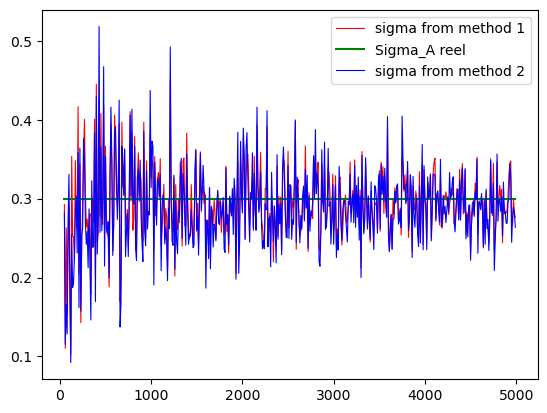

In [61]:
sigma_a=0.3
H=0.6
mu=0
T=1

sigma_1=[]
sigma_2=[]
err_sigma1=[]
err_sigma2=[]

liste_n=[]
r_s=[]

for n in range(50,5000,10):
    liste_n.append(n)
    s1,s2,e1,e2=sigma_error(sigma_a,mu,H,n,n_it=10)
    sigma_1.append(s1)
    sigma_2.append(s2)

    #err_sigma.append(e)
    r_s.append(sigma_a)


plt.plot(liste_n,sigma_1,label="sigma from method 1",linewidth=0.8,color='r')
plt.plot(liste_n,r_s,label="Sigma_A reel",linewidth=1.5,color="green")
plt.plot(liste_n,sigma_2,label="sigma from method 2",linewidth=0.8,color="blue")
plt.legend()